This Jupyter notebook contains all code to data visualization of the LLM.

Table for Claude Opus4 saved as ../dataset/evals/multi_comparison/Claude_Opus4_table.png
CSV for Claude Opus4 saved as ../dataset/evals/multi_comparison/Claude_Opus4_table.csv
Table for CodeLlama 7B Ins (no-sm) saved as ../dataset/evals/multi_comparison/CodeLlama_7B_Ins_(no-sm)_table.png
CSV for CodeLlama 7B Ins (no-sm) saved as ../dataset/evals/multi_comparison/CodeLlama_7B_Ins_(no-sm)_table.csv
Table for Deepseek Coder 7B Ins v1.5 saved as ../dataset/evals/multi_comparison/Deepseek_Coder_7B_Ins_v1.5_table.png
CSV for Deepseek Coder 7B Ins v1.5 saved as ../dataset/evals/multi_comparison/Deepseek_Coder_7B_Ins_v1.5_table.csv
Table for OpenAI GPT4.1 saved as ../dataset/evals/multi_comparison/OpenAI_GPT4.1_table.png
CSV for OpenAI GPT4.1 saved as ../dataset/evals/multi_comparison/OpenAI_GPT4.1_table.csv
Table for Qwen Coder2.5 7B Instruct saved as ../dataset/evals/multi_comparison/Qwen_Coder2.5_7B_Instruct_table.png
CSV for Qwen Coder2.5 7B Instruct saved as ../dataset/evals/multi_compari

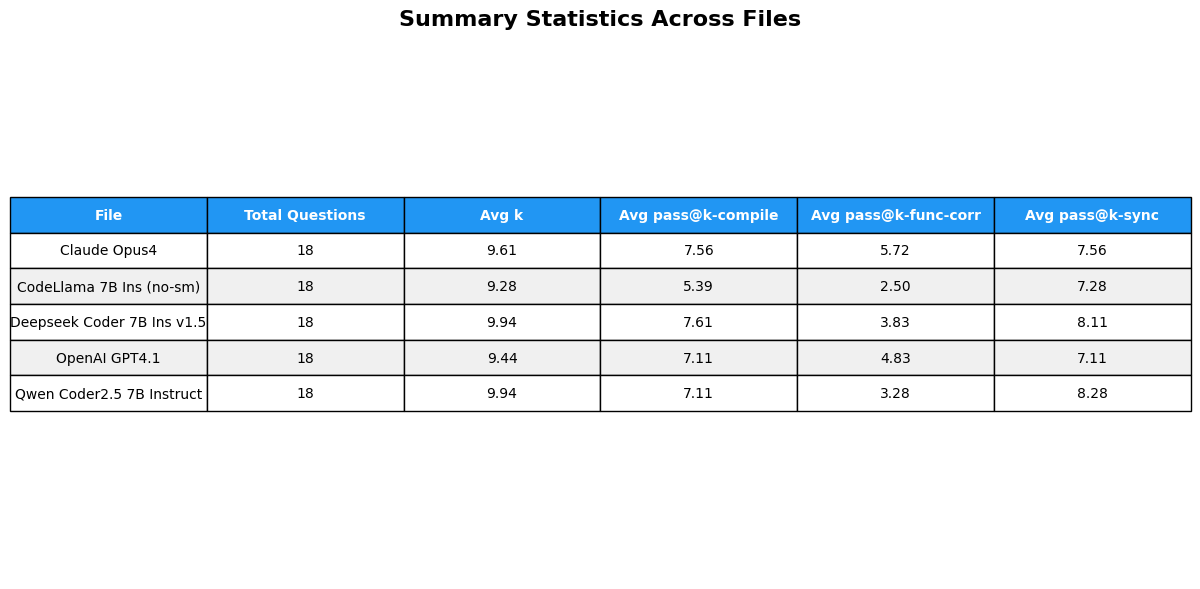

Creating table for model: Claude Opus4
             Avg k  Avg pass@k-compile  Avg pass@k-func-corr  Avg pass@k-sync
Difficulty                                                                   
basic       10.000                 6.0                  10.0              6.0
medium       9.125                 7.5                   5.0              7.5
hard        10.000                 9.2                   2.6              9.2
Creating table for model: CodeLlama 7B Ins (no-sm)
            Avg k  Avg pass@k-compile  Avg pass@k-func-corr  Avg pass@k-sync
Difficulty                                                                  
basic         7.4               5.800                   5.4            5.800
medium       10.0               4.375                   2.0            7.625
hard         10.0               6.600                   0.4            8.200
Creating table for model: Deepseek Coder 7B Ins v1.5
            Avg k  Avg pass@k-compile  Avg pass@k-func-corr  Avg pass@k-sync
Diffi

In [64]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
import os


def load_json_data(file_path):
    """Load JSON data from file"""
    with open(file_path, "r") as f:
        data = json.load(f)
    return data


def create_individual_tables(
    file_paths: List[str], output_dir: str, file_labels: List[str] = None
):
    """
    Create separate individual tables for each JSON file

    Parameters:
    -----------
    file_paths:     List[str]
        List of paths to JSON files
    output_dir:    str
        Name of output directory path
    file_labels:    List[str]
        Optional list of labels for each file

    Returns:
    --------
    None
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Use custom labels or default to File 1, File 2, etc.
    if file_labels is None:
        file_labels = [f"File {i + 1}" for i in range(len(file_paths))]

    all_dataframes = []

    # Process each file separately
    for idx, (path, label) in enumerate(zip(file_paths, file_labels)):
        # Load data
        data = load_json_data(path)
        # Ensure data is in list format
        if not isinstance(data, list):
            data = [data]

        # Create column headers for this file
        columns = [
            "Question",
            "Difficulty",
            "k",
            "pass@k-compile",
            "pass@k-func-corr",
            "pass@k-sync",
        ]

        # Create table data
        table_data = []

        for item in data:
            # Truncate long questions
            question = item["question"]
            if len(question) > 60:
                question = question[:57] + "..."

            row = [
                question,
                item["difficulty"],
                item["evals"]["k"],
                item["evals"]["pass@k-compile"],
                item["evals"]["pass@k-func-corr"],
                item["evals"]["pass@k-sync"],
            ]
            table_data.append(row)

        # Create DataFrame
        df = pd.DataFrame(table_data, columns=columns)
        all_dataframes.append(df)

        # Create figure
        fig_width = 14
        fig_height = min(20, len(df) * 0.5 + 2)

        fig, ax = plt.subplots(figsize=(fig_width, fig_height))
        ax.axis("tight")
        ax.axis("off")

        # Create table
        table = ax.table(
            cellText=df.values, colLabels=df.columns, cellLoc="center", loc="center"
        )

        # Style the table
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)

        # Color header row
        for i in range(len(columns)):
            table[(0, i)].set_facecolor("#4CAF50")
            table[(0, i)].set_text_props(weight="bold", color="white")

        # Color alternating rows
        for i in range(1, len(df) + 1):
            if i % 2 == 0:
                for j in range(len(columns)):
                    table[(i, j)].set_facecolor("#f0f0f0")

        # Adjust column widths
        cellDict = table.get_celld()
        for i in range(len(df) + 1):
            cellDict[(i, 0)].set_width(0.4)  # Question column wider
            cellDict[(i, 1)].set_width(0.1)  # Difficulty
            for j in range(2, len(columns)):
                cellDict[(i, j)].set_width(0.1)

        plt.title(
            f"{label} - Evaluation Results", fontsize=16, fontweight="bold", pad=6
        )
        plt.tight_layout()

        # Save files
        output_filepath = os.path.join(
            output_dir, f"{label.replace(' ', '_')}_table.png"
        )
        plt.savefig(output_filepath, dpi=300, bbox_inches="tight")
        plt.close()  # Close figure to free memory

        # Save as CSV
        csv_file = output_filepath.replace(".png", ".csv")
        df.to_csv(csv_file, index=False)

        print(f"Table for {label} saved as {output_filepath}")
        print(f"CSV for {label} saved as {csv_file}")

    return all_dataframes


def create_comparison_summary(
    file_paths: List[str],
    output_file: str = "summary_table.png",
    file_labels: List[str] = None,
):
    """
    Create a summary table showing aggregated metrics for each file

    Parameters:
    -----------
    file_paths:     List[str]
        List of paths to JSON files
    output_file:    str
        Name of output image file
    file_labels:    List[str]
        Optional list of labels for each file

    Returns:
    --------
    None
    """
    # Load data from all files
    all_data = []
    for path in file_paths:
        data = load_json_data(path)
        if not isinstance(data, list):
            data = [data]
        all_data.append(data)

    # Use custom labels or default
    if file_labels is None:
        file_labels = [f"File {i + 1}" for i in range(len(file_paths))]

    # Calculate summary statistics
    summary_data = []

    for idx, data in enumerate(all_data):
        total_questions = len(data)
        avg_k = (
            sum(item["evals"]["k"] for item in data) / total_questions
            if total_questions > 0
            else 0
        )
        avg_compile = (
            sum(item["evals"]["pass@k-compile"] for item in data) / total_questions
            if total_questions > 0
            else 0
        )
        avg_func_corr = (
            sum(item["evals"]["pass@k-func-corr"] for item in data) / total_questions
            if total_questions > 0
            else 0
        )
        avg_sync = (
            sum(item["evals"]["pass@k-sync"] for item in data) / total_questions
            if total_questions > 0
            else 0
        )

        summary_data.append(
            [
                file_labels[idx],
                total_questions,
                f"{avg_k:.2f}",
                f"{avg_compile:.2f}",
                f"{avg_func_corr:.2f}",
                f"{avg_sync:.2f}",
            ]
        )

    # Create DataFrame
    columns = [
        "File",
        "Total Questions",
        "Avg k",
        "Avg pass@k-compile",
        "Avg pass@k-func-corr",
        "Avg pass@k-sync",
    ]
    df_summary = pd.DataFrame(summary_data, columns=columns)

    # Create figure
    fig, ax = plt.subplots(figsize=(12, len(df_summary) * 0.8 + 2))
    ax.axis("tight")
    ax.axis("off")

    # Create table
    table = ax.table(
        cellText=df_summary.values,
        colLabels=df_summary.columns,
        cellLoc="center",
        loc="center",
    )

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.8)

    # Color header row
    for i in range(len(columns)):
        table[(0, i)].set_facecolor("#2196F3")
        table[(0, i)].set_text_props(weight="bold", color="white")

    # Color alternating rows
    for i in range(1, len(df_summary) + 1):
        if i % 2 == 0:
            for j in range(len(columns)):
                table[(i, j)].set_facecolor("#f0f0f0")

    plt.title("Summary Statistics Across Files", fontsize=16, fontweight="bold", pad=2)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()

    return df_summary


def create_difficulty_lvl_summary(model_labels: List[str] = None):
    """
    Create table showing avg Pass@k metric for each level of difficulty per questions (for each LLM)

    Parameters:
    -----------
    model_labels:    List[str]
        Model labels containing model name - used in reading CSV file(s)

    Returns:
    --------
    None
    """

    output_path = "dataset/evals/multi_comparison"
    for model_label in model_labels:
        csv_filepath = os.path.join(
            "..", output_path, f"{model_label.replace(' ', '_')}_table.csv"
        )
        if os.path.exists(csv_filepath):
            df = pd.read_csv(csv_filepath)

            # Group by difficulty and compute mean of numeric columns w/o ordering
            difficulty_order = ["basic", "medium", "hard"]
            summary_df = (
                df.groupby("Difficulty", sort=False)
                .mean(numeric_only=True)
                .round(3)
                .reindex(difficulty_order)
            )

            if summary_df.empty:
                print(f"No data to display for {model_label}")
                continue

            summary_df.columns = ["Avg " + col for col in summary_df.columns]
            print(f"Creating table for model: {model_label}")
            print(summary_df)

            # Add 'Difficulty' to the column headers
            col_labels = ["Difficulty"] + list(summary_df.columns)
            cell_text = [
                [idx] + list(row)
                for idx, row in zip(summary_df.index, summary_df.values)
            ]

            # Plot the summary table
            fig, ax = plt.subplots(figsize=(12, len(summary_df) * 0.8 + 2))
            ax.axis("off")
            table = ax.table(cellText=cell_text, colLabels=col_labels, loc="center")
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(0.8, 1.8)

            # Color header row
            for i in range(len(col_labels)):
                table[(0, i)].set_facecolor("#2196F3")
                table[(0, i)].set_text_props(weight="bold", color="white")

            # Format first column of each row: capitalize and center-align
            for i in range(1, len(summary_df) + 1):  # Skip header row (row 0)
                cell = table[(i, 0)]

                # Capitalize all words
                original_text = cell.get_text().get_text()
                capitalized_text = original_text.title()
                cell.get_text().set_text(capitalized_text)

                # Bold and center the text
                cell.set_text_props(weight="bold", ha="center", va="center")

            ax.set_title(
                f"Difficulty-Level Pass@k Summary for {model_label}",
                fontsize=14,
                fontweight="bold",
                pad=12,
            )

            # Save figure
            filename = f"{model_label.replace(' ', '_')}_diff_summary.png"
            plt.tight_layout()
            plt.savefig(os.path.join("..", output_path, filename), dpi=300)
            plt.close()
        else:
            print("CSV Data of Pass@k metric doesn't exist. Try running again")


def find_json_files(directory: str):
    """
    Find all JSON files in a directory

    Parameters:
    -----------
    directory:  str
        Directory (path)

    Returns:
    --------
    None
    """
    json_files = []
    for file in os.listdir(directory):
        if file.endswith(".json"):
            json_files.append(os.path.join(directory, file))
    return sorted(json_files)


# Example usage
if __name__ == "__main__":
    # Example 1: Compare specific files
    eval_dataset_path = "dataset/evals"
    target = os.path.join("..", eval_dataset_path)

    file_paths = find_json_files(target)
    labels = [
        "Claude Opus4",
        "CodeLlama 7B Ins (no-sm)",
        "Deepseek Coder 7B Ins v1.5",
        "OpenAI GPT4.1",
        "Qwen Coder2.5 7B Instruct",
    ]

    # Uncomment to run:
    create_individual_tables(
        file_paths, os.path.join("..", eval_dataset_path, "multi_comparison"), labels
    )
    create_comparison_summary(
        file_paths, os.path.join("..", eval_dataset_path, "summary.png"), labels
    )
    create_difficulty_lvl_summary(labels)

    # Example 2: Compare all JSON files in a directory
    # json_files = find_json_files('./results/')
    # create_multi_file_comparison(json_files, 'all_files_comparison.png')

    print("Script ready for multiple JSON file comparison!")